In [1]:
import psutil
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, cm
import matplotlib.animation as animation
from pystencils.session import *
from pystencils.boundaries import add_neumann_boundary, Neumann, Dirichlet, BoundaryHandling
from pystencils.slicing import slice_from_direction
import math
import time
%matplotlib inline

In [2]:
dh = ps.create_data_handling(domain_size=(256, 256), periodicity=True)  # able to organize data on 256x256 lattice
μ_field = dh.add_array('mu', latex_name='μ', ghost_layers=2)  # chemical potential (functional derivative of free energy)
c_field = dh.add_array('c', ghost_layers=2)  # raw concentration that free energy depends on

In [3]:
ε, q_0, γ = sp.symbols("ε q_0 γ")

c = c_field.center
μ = μ_field.center

def f(c):
    return -ε*c**2/2 + c**4/4

bulk_free_energy_density = f(c)

covariant_free_energy_density = 1/2 * c**2

grad_sq = sum(ps.fd.diff(c, i)**2 for i in range(dh.dim))
interfacial_free_energy_density = -grad_sq

grad_fourth = sum(ps.fd.diff(ps.fd.diff(c, i), i)**2 for i in range(dh.dim)) + 2*ps.fd.diff(ps.fd.diff(c, 0), 0)*ps.fd.diff(ps.fd.diff(c, 1), 1)
interface_deformation_free_energy_density = 1/2 * grad_fourth

free_energy_density = bulk_free_energy_density + covariant_free_energy_density + interfacial_free_energy_density + interface_deformation_free_energy_density
free_energy_density

   4      2                                                                   
c_C    c_C ⋅ε          2            2            2                   2        
──── - ────── + 0.5⋅c_C  - D(c[0,0])  - D(c[0,0])  + 0.5⋅D(D(c[0,0]))  + 1.0⋅D
 4       2                                                                    

                                            
                                           2
(D(c[0,0]))⋅D(D(c[0,0])) + 0.5⋅D(D(c[0,0])) 
                                            

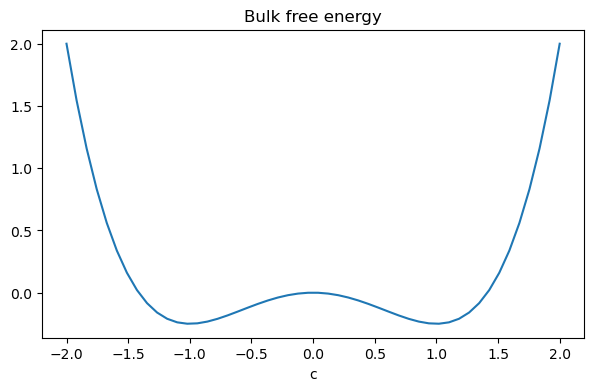

In [4]:
plt.figure(figsize=(7,4))
plt.sympy_function(bulk_free_energy_density.subs(ε, 1), (-2, 2))
plt.xlabel("c")
plt.title("Bulk free energy");

In [5]:
# here we manually write the update equation for chemical potential μ because 
# Pystencils functional derivative method cannot handle mixed partial derivatives
def bulk_deriv(c):
    return -ε*c + c**3

μ_bulk = bulk_deriv(c)

μ_covariant = c

laplacian = sum(ps.fd.diff(c, i, i) for i in range(dh.dim))
μ_interfacial = 2*laplacian

grad_fourth = sum(ps.fd.diff(c, i, i, i, i) for i in range(dh.dim)) + 2*ps.fd.diff(c, 1, 1, 0, 0)
μ_interface_deformation = grad_fourth

μ_update_eq = μ_bulk + μ_covariant + μ_interfacial + μ_interface_deformation

μ_update_eq

   3                                                                          
c_C  - c_C⋅ε + c_C + 2⋅D(D(c[0,0])) + 2⋅D(D(c[0,0])) + D(D(D(D(c[0,0])))) + 2⋅

                                       
D(D(D(D(c[0,0])))) + D(D(D(D(c[0,0]))))

In [6]:
'''
It turns out the inbuilt discretization functions neither work for above 2nd order differential equations...
Let's do this part by hand too, and hope it works.
'''
discretize_2ndorderPDEs = ps.fd.Discretization2ndOrder(dx=1, dt=0.002)

μ_interfacial_discretized = discretize_2ndorderPDEs(μ_interfacial)

μ_interfacial_discretized

In [7]:
#we must recursively leverage the in-built function for discretizing 2nd order PDEs in order to discretize our 4th order one
second_grad_0 = ps.fd.diff(c,0,0)
second_grad_1 = ps.fd.diff(c,1,1)

second_grad_0_discretized = discretize_2ndorderPDEs(second_grad_0)
second_grad_1_discretized = discretize_2ndorderPDEs(second_grad_1)

fourth_grad_0 = ps.fd.diff(second_grad_0_discretized,0,0)
fourth_grad_0 = ps.fd.expand_diff_linear(fourth_grad_0)
fourth_grad_1 = ps.fd.diff(second_grad_1_discretized,1,1)
fourth_grad_1 = ps.fd.expand_diff_linear(fourth_grad_1)

fourth_grad_0_discretized = discretize_2ndorderPDEs(fourth_grad_0)
fourth_grad_1_discretized = discretize_2ndorderPDEs(fourth_grad_1)


fourth_grad_mixed = ps.fd.diff(second_grad_0_discretized,1,1)
fourth_grad_mixed = ps.fd.expand_diff_linear(fourth_grad_mixed)


fourth_grad_mixed_discretized = 2*discretize_2ndorderPDEs(fourth_grad_mixed)


μ_interface_deformation_discretized = fourth_grad_0_discretized + fourth_grad_1_discretized + fourth_grad_mixed_discretized
μ_interface_deformation_discretized

In [8]:
μ_update_eq_discretized = μ_bulk + μ_covariant + μ_interfacial_discretized + μ_interface_deformation_discretized
μ_update_eq_discretized

In [9]:
μ_kernel = ps.create_kernel([ps.Assignment(μ_field.center,
                                           μ_update_eq_discretized.subs(ε, 0.1))]
                           ).compile()
# here we define the update function of the chemical potential BEFORE that of yhe concentration

In [10]:
M = sp.Symbol("M")
# after suffering through the defining the dynamics of the chemical potential, 
# we know full dynamics is just the diffusionary Fick's Law of that
conserved_swift_hohenberg = ps.fd.transient(c) - ps.fd.diffusion(μ, M)  # continuity equation! M is mobility (diffusion) coefficient
conserved_swift_hohenberg

-Diffusion(μ_C, M) + Transient(c_C)

In [11]:
# 2nd order discretization of the second derivative, the middle term compounds
c_update = discretize_2ndorderPDEs(conserved_swift_hohenberg) 
c_update  # this is the symbolic rule of how c updates

In [12]:
c_kernel = ps.create_kernel([ps.Assignment(c_field.center,
                                           c_update.subs(M, 1))]
                           ).compile()

In [13]:
dh.ghost_layers_of_field('c')

In [14]:
# no boundary functions because periodicity was already set in the data handler
def init(value=0.4, noise=0.02):
    for b in dh.iterate(ghost_layers=2):  # iterate() contains each domain! so an entire lattice block is each term of iterate
        b['c'].fill(value)
        np.add(b['c'], noise*np.random.rand(*b['c'].shape), out=b['c'])

In [15]:
def timeloop(steps=100):
    c_sync = dh.synchronization_function(['c'])
    μ_sync = dh.synchronization_function(['mu'])
    for t in range(steps):
        c_sync()
        dh.run_kernel(μ_kernel)  # need chemical potential to update first
        μ_sync()
        dh.run_kernel(c_kernel)  # followed by concentration dynamics from the chemical potential
    return dh.gather_array('c')

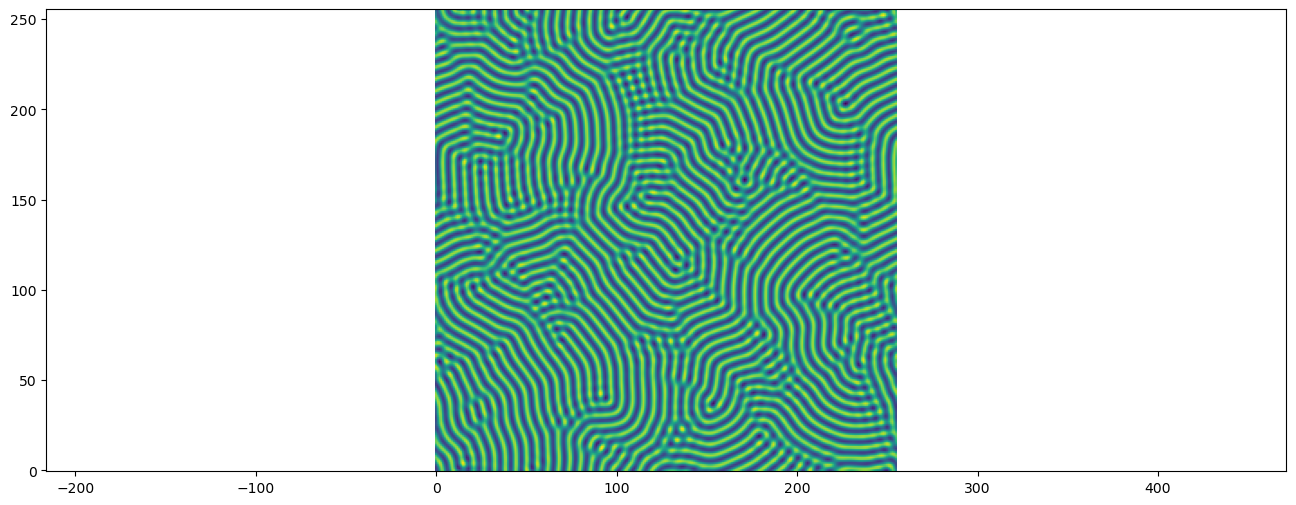

In [16]:
init(0,0.01) # initialize the system at time = 0
# run the simulation and save a video in time
ani = ps.plot.scalar_field_animation(timeloop, rescale=True, frames=1500)
writervideo = animation.FFMpegWriter(fps=60)
ani.save(r'C:\Users\taylo\UU Thesis - Smectodynamics of Dividing Cells\Pystencils Videos\swift-hohenberg.mp4', writer=writervideo)

In [124]:
init(0,0.01)
timeloop(steps=15)
c_arr = dh.cpu_arrays['c']
c_arr

(260, 260)


array([[ -4.66247375,   4.66994801,  -4.32826144, ...,   4.66994801,
         -4.32826144,   3.7683531 ],
       [  4.4802191 ,  16.28015759, -15.24742329, ...,  16.28015759,
        -15.24742329,  -4.02573696],
       [ -4.19251205, -15.44279862,  15.41417983, ..., -15.44279862,
         15.41417983,   4.21037552],
       ...,
       [  4.4802191 ,  16.28015759, -15.24742329, ...,  16.28015759,
        -15.24742329,  -4.02573696],
       [ -4.19251205, -15.44279862,  15.41417983, ..., -15.44279862,
         15.41417983,   4.21037552],
       [  3.81293249,  -4.28668325,   4.43287178, ...,  -4.28668325,
          4.43287178,  -4.21376761]])